In [1]:
import os
import sys
import pickle
import numpy as np
from PIL import Image

from pathlib import Path

project_root = Path(os.path.abspath('')).parent.parent
sys.path.append(str(project_root))


from dotenv import load_dotenv 
load_dotenv()

NIH_CXR14_DATASET_DIR = os.getenv("NIH_CXR14_DATASET_DIR")
INTERMEDIATE_DATA_DIR = project_root / "data"
print(NIH_CXR14_DATASET_DIR)
print(INTERMEDIATE_DATA_DIR)



/home/yasin/Lfstorage/datasets/nih-cxr14/original
/home/yasin/Lfstorage/Projects/cxr-diffusion/data


In [2]:
import torch
from torch.utils.data import Dataset
import torch.optim as optim
from diffusers import DDPMScheduler, UNet2DConditionModel


/home/yasin/Lfstorage/Projects/cxr-diffusion/.venv/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-03-11 00:25:38.467306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741641938.490352 1668774 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741641938.497250 1668774 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 00:25:38.522262: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.


In [3]:
class Diffusion():
    def __init__(self, model, scheduler, processor,num_inference_step=50):
        self.model = model
        self.scheduler = scheduler
        self.processor = processor
        self.num_inference_step = num_inference_step
        self.device = next(model.parameters()).device

    def generate(self, cond_embed, latent):
        if latent is None:
            generator = torch.Generator(device=self.device).manual_seed(np.random.randint(0, 1000000))
            latent = torch.randn((1,4,64,64), device = self.device, generator=generator)
        self.scheduler.set_timesteps(self.num_inference_step)
        timesteps = self.scheduler.timesteps

        cond_embed = cond_embed.to(self.device)

        with torch.no_grad():
            for t in timesteps:
                latent_model_input = latent
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
                noise_pred = self.model(
                    latent_model_input,
                    t,
                    encoder_hidden_states=cond_embed
                ).sample

                latent = self.scheduler.step(noise_pred, t, latent).prev_sample
            
            image = self.processor.decode_latent(latent)[0]
        return image
        

In [4]:
def prepare_cond_input(embeddings, padding=True):
    if isinstance(embeddings, np.ndarray):
        embeddings = torch.tensor(embeddings)
    if padding:
        padding_size = 77 - embeddings.shape[0]
        padding = torch.zeros((padding_size, embeddings.shape[1]))
        embeddings = torch.cat((embeddings, padding), dim=0)

        #add batch dimension
        embeddings = embeddings.unsqueeze(0)
    return embeddings

def prepare_latent_input(image,processor):
    image = processor.encode_image(image)
    return image

def decode_latent(image, processor):
    return processor.decode_latent(image)


In [25]:
from matplotlib import pyplot as plt


def show_grid(images, images_titles, rows, main_title=None):
    cols = len(images) // rows

    # Adjust figsize based on the number of rows
    if rows == 1:
        fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, 2.5))  # Adjusted height
    else:
        fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

    if main_title:
        fig.suptitle(main_title, fontsize=16)

    if rows == 1:  # Handle 1-row case
        for i, (image, title) in enumerate(zip(images, images_titles)):
            axs[i].imshow(image, cmap="gray")
            axs[i].axis("off")
            axs[i].set_title(title, fontsize=8, pad=5)  # Add padding
    else:  # Handle multi-row case
        for i, (image, title) in enumerate(zip(images, images_titles)):
            ax = axs[i // cols, i % cols]
            ax.imshow(image, cmap="gray")
            ax.axis("off")
            ax.set_title(title, fontsize=8, pad=5) # Add padding

    plt.tight_layout(pad=1.5) #Add padding to tight_layout
    return fig

In [6]:
clip_text_embeddings_path = INTERMEDIATE_DATA_DIR / "clip_text_embeds.pkl"
unet_model_path = "./output/best/"

In [7]:
device = "cuda:2"
num_inference_step = 50


In [8]:
unet = UNet2DConditionModel().from_pretrained(unet_model_path)
unet.to(device)


UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [9]:
from src.pipelines import VaeProcessor
from src.datasets import NIHImageDataset

dataset = NIHImageDataset(NIH_CXR14_DATASET_DIR)


with open(clip_text_embeddings_path, "rb") as f:
    clip_text_embeddings = pickle.load(f)



img_idxs = list(clip_text_embeddings.keys())

dataset = dataset.filter_by_id(img_idxs)




processor = VaeProcessor(device=device)

scheduler = DDPMScheduler()


In [10]:
random_sample = np.random.choice(len(dataset), 24)


idxs = [img_idxs[i] for i in random_sample]

images = []
for idx in idxs:
    _, image = dataset[idx]
    images.append(image)

text_embeds = [clip_text_embeddings[idx] for idx in idxs]

In [11]:
idxs

['00004946_002.png',
 '00000979_008.png',
 '00016964_007.png',
 '00005185_001.png',
 '00004542_005.png',
 '00000137_001.png',
 '00014223_008.png',
 '00013387_001.png',
 '00019680_007.png',
 '00003122_012.png',
 '00003198_004.png',
 '00004268_000.png',
 '00020335_000.png',
 '00001714_001.png',
 '00001200_014.png',
 '00006868_015.png',
 '00010841_010.png',
 '00000502_011.png',
 '00009273_003.png',
 '00015732_040.png',
 '00019610_008.png',
 '00006304_037.png',
 '00005403_011.png',
 '00030683_001.png']

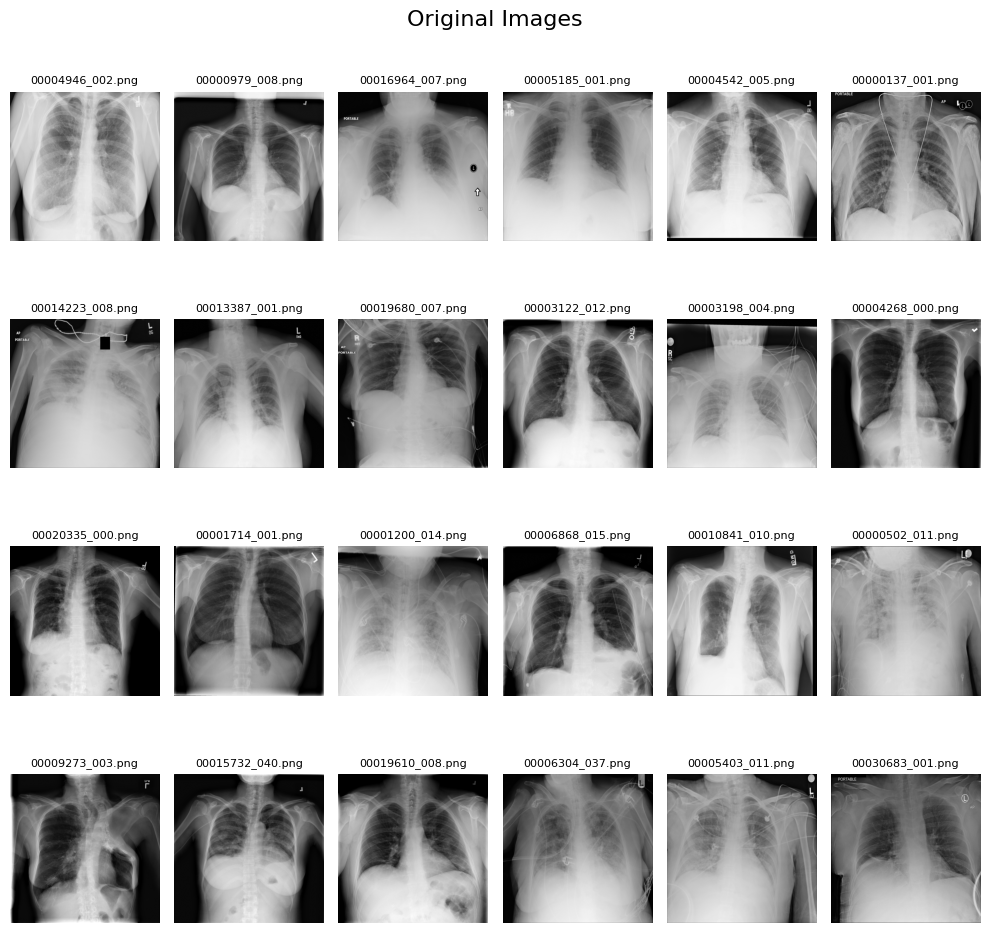

In [12]:
gray_images = [image.convert("L") for image in images]

fig = show_grid(gray_images, idxs, 4, "Original Images")

fig.show()

In [13]:
diffusion= Diffusion(unet, scheduler, processor, num_inference_step=num_inference_step)


In [14]:
generated_images = []
for text_embed in text_embeds:
    cond_input = prepare_cond_input(text_embed)
    image = diffusion.generate(cond_input, None)
    generated_images.append(image)

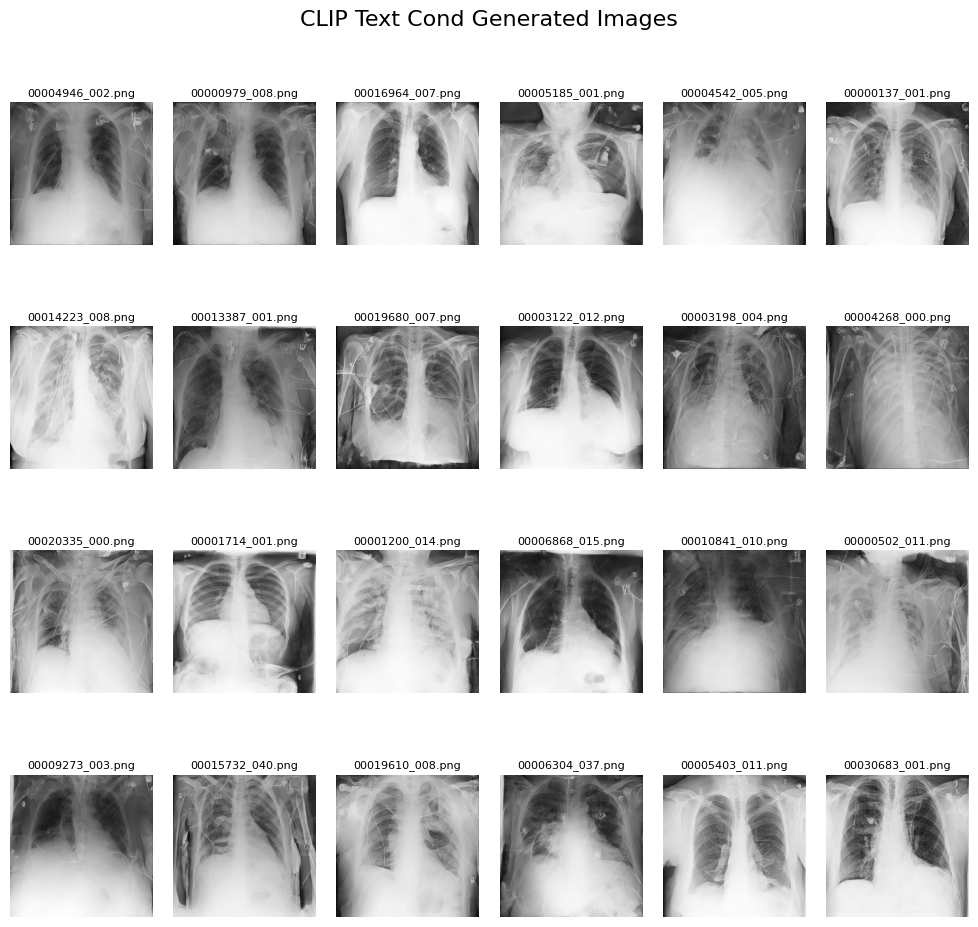

: 

In [ ]:
generated_gray_images = [image.convert("L") for image in generated_images]

fig = show_grid(generated_gray_images, idxs, 4, "CLIP Text Cond Generated Images")

fig.show()

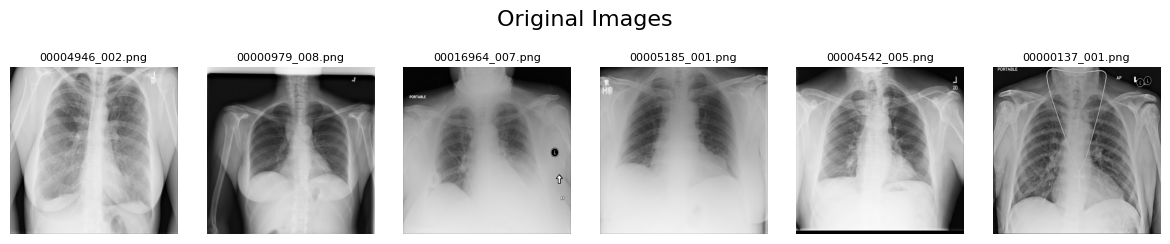

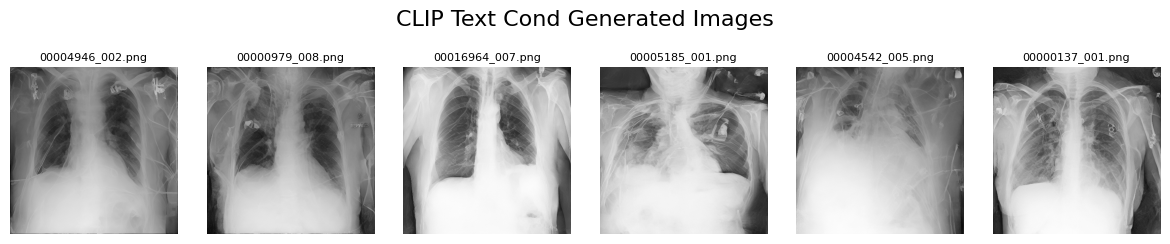

In [34]:
six_sample_idxs = idxs[:6]
six_sample_gray_images = gray_images[:6]
six_sample_generated_gray_images = generated_gray_images[:6]

fig_original = show_grid(six_sample_gray_images, six_sample_idxs, 1, "Original Images")
fig_generated = show_grid(six_sample_generated_gray_images, six_sample_idxs, 1, "CLIP Text Cond Generated Images")
